In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import csv
import json
import sklearn
from google.cloud import bigquery as bq
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
# Set random seeds

sampling_seed = np.random.seed(13)
train_test_seed = np.random.seed(69)
cv_seed = np.random.seed(37)
model_seed = np.random.seed(73)
np.random.seed(42) # set default seed value

In [4]:
query="""
    SELECT
      osm_way_id AS osm_way_id,
      bag3d_height AS bldg_height,
      area,
      perimeter,
      length,
      IFNULL(SAFE_CAST(building_levels AS INT64), 1) AS building_levels,
      IFNULL(city, "") AS city,
      IFNULL(country, "") AS country,
      IFNULL(postcode , "") AS postcode,
      IFNULL(
          CASE
              WHEN SAFE_CAST(REGEXP_EXTRACT(start_date, r"(\d{4})") AS INT64) > EXTRACT(YEAR FROM CURRENT_DATE()) THEN NULL
              ELSE SAFE_CAST(REGEXP_EXTRACT(start_date, r"(\d{4})") AS INT64)
          END, 
          1970.0
      ) AS year,
      count_vertices,
      compactness,
      complexity,
      IFNULL(SAFE_CAST(count_neighbor AS INT64), 0.0) AS count_neighbor,
      IFNULL(state_name , "") AS state_name
    FROM
      `ual3d-277909.nl.zuid_holland_buildings_wide_features` 
    WHERE bag3d_height IS NOT NULL
      AND state_name = 'South Holland'
"""



In [5]:
df = bq.Client().query(query).to_dataframe()
df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
0,274037235,2.35,13.908637,17.040154,6.691464,1,,NL,,1937.0,5,0.775843,8.823733,843.0,South Holland
1,287836907,8.29,90.610117,43.127338,16.339486,1,,NL,,1936.0,11,0.782421,13.978433,1031.0,South Holland
2,284521210,3.28,6.844828,10.619743,3.820897,1,,NL,,1943.0,5,0.873318,6.565584,767.0,South Holland
3,266451482,9.80,106.160289,57.199138,24.086881,1,,NL,,1905.0,13,0.638552,17.819642,639.0,South Holland
4,267557698,2.26,20.234171,21.339247,8.579122,1,,NL,,1887.0,8,0.747255,10.061384,784.0,South Holland


In [6]:
df.set_index('osm_way_id', inplace=True)

In [7]:
df.shape

(1638666, 14)

In [8]:
df.dtypes

bldg_height        float64
area               float64
perimeter          float64
length             float64
building_levels      int64
city                object
country             object
postcode            object
year               float64
count_vertices       int64
compactness        float64
complexity         float64
count_neighbor     float64
state_name          object
dtype: object

In [9]:
df["city"] = df["city"].astype("category")
df["state_name"] = df["state_name"].astype("category")
df["country"] = df["country"].astype("category")
df["postcode"] = df["postcode"].astype("category")
df.dtypes

bldg_height         float64
area                float64
perimeter           float64
length              float64
building_levels       int64
city               category
country            category
postcode           category
year                float64
count_vertices        int64
compactness         float64
complexity          float64
count_neighbor      float64
state_name         category
dtype: object

In [10]:
label_col = ["bldg_height"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
# num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity"]
# cat_cols = ["city", "country", postcode", "state_name"]
cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]
# drop country as it is irrelevant 


In [11]:
print('unique city:', pd.unique(df['city']))
print('unique postcode:', pd.unique(df['postcode']))

unique city: [, Vlaardingen, 's-Gravenhage, Bodegraven, Rotterdam, ..., Klaaswaal, Ottoland, Rozenburg, Brielle, Nieuwveen]
Length: 102
Categories (102, object): [, Vlaardingen, 's-Gravenhage, Bodegraven, ..., Ottoland, Rozenburg, Brielle, Nieuwveen]
unique postcode: [, 3135KP, 2411RX, 3029BP, 2513BA, ..., 3316AK, 2253XG, 2552SB, 3085KA, 3063NN]
Length: 683
Categories (683, object): [, 3135KP, 2411RX, 3029BP, ..., 2253XG, 2552SB, 3085KA, 3063NN]


In [12]:
df.isna().sum()

bldg_height        0
area               0
perimeter          0
length             0
building_levels    0
city               0
country            0
postcode           0
year               0
count_vertices     0
compactness        0
complexity         0
count_neighbor     0
state_name         0
dtype: int64

In [13]:
cat_df = df[cat_cols]
num_df = df[num_cols]

In [14]:
num_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,1.638666e+06,1.638666e+06,1.638666e+06,1.638666e+06,1.638666e+06,1.638666e+06,1.638666e+06,1.638666e+06,1.638666e+06
mean,1.284413e+02,3.442989e+01,1.248890e+01,1.007538e+00,1.970038e+03,7.308884e+00,8.203220e-01,1.150416e+01,6.270549e+02
std,1.201438e+03,4.307075e+01,1.500313e+01,2.078337e-01,3.692439e+01,5.192885e+00,7.008799e-02,5.160273e+00,3.078407e+02
min,2.650812e-04,8.183244e-02,3.404680e-02,-4.000000e+00,1.131000e+03,4.000000e+00,2.828082e-02,6.413288e-01,0.000000e+00
25%,1.107290e+01,1.383930e+01,5.054998e+00,1.000000e+00,1.957000e+03,5.000000e+00,7.915906e-01,7.573893e+00,4.300000e+02
50%,5.009999e+01,2.977105e+01,1.085595e+01,1.000000e+00,1.976000e+03,5.000000e+00,8.439439e-01,1.113455e+01,6.390000e+02
75%,7.143773e+01,3.887442e+01,1.431944e+01,1.000000e+00,1.993000e+03,8.000000e+00,8.719881e-01,1.333404e+01,8.330000e+02
max,2.562055e+05,3.925806e+03,9.652139e+02,4.400000e+01,2.020000e+03,7.930000e+02,9.999417e-01,2.340868e+02,2.143000e+03


area                  AxesSubplot(0.125,0.125;0.0731132x0.755)
perimeter          AxesSubplot(0.212736,0.125;0.0731132x0.755)
length             AxesSubplot(0.300472,0.125;0.0731132x0.755)
building_levels    AxesSubplot(0.388208,0.125;0.0731132x0.755)
year               AxesSubplot(0.475943,0.125;0.0731132x0.755)
count_vertices     AxesSubplot(0.563679,0.125;0.0731132x0.755)
compactness        AxesSubplot(0.651415,0.125;0.0731132x0.755)
complexity         AxesSubplot(0.739151,0.125;0.0731132x0.755)
count_neighbor     AxesSubplot(0.826887,0.125;0.0731132x0.755)
dtype: object

[]

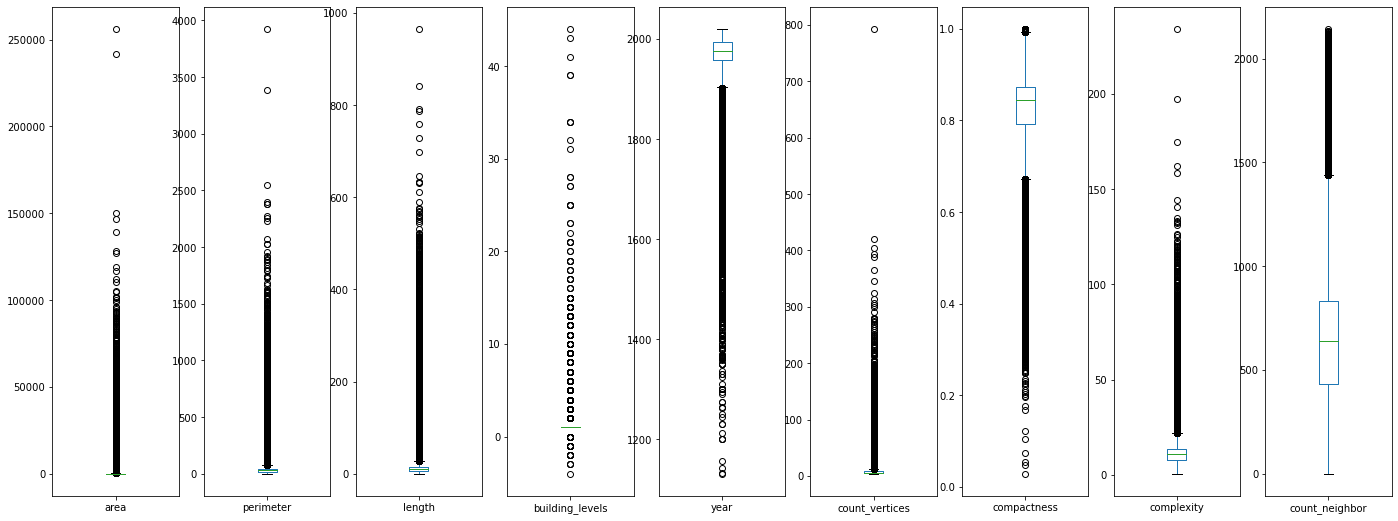

In [15]:
num_df.plot(kind='box', subplots=True, figsize=(24,9))
plt.plot()
plt.savefig('exploratory_full/south_holland_basic_distribution.png')